Steps and methods covered in this notebook
- Read the main dataset
- Drop the unnecessary columns
- Drop the rows having more than 2 null values in the remaining columns
</n>
- Implement the MICE and Autoencoders imputation
- Then use Cluster-based SMOTE (KMeans SMOTE) for both the Mice and AE datasets
</n>
- Before last step - group the columns under thier headers
- As a last step implement PCA for both the datasets and save the datasets as excel files separately


(Refer the Preprocessing_PCA_SMOTE.ipynb for the lines of code)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from sklearn.ensemble import IsolationForest
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import shap
import lime
from lime import lime_tabular

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

from sklearn.cluster import KMeans

import missingno as msno

from fancyimpute import IterativeImputer as MICE
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam 


from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from collections import Counter

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import KMeansSMOTE
from sklearn.mixture import GaussianMixture


from xgboost import XGBClassifier
from rgf.sklearn import RGFClassifier  # Regularized Greedy Forest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from joblib import dump, load
import logging

import time


In [16]:
def preprocess_dataframe(df):

    start_time = time.time()  # Start timing

    # Replace LABEL values from integers to string
    df["LABEL"] = df["LABEL"].replace({0: "Normal", 1: "Distressed"})
    df["ID"] = df["ID"].replace({0: "changed"})
    
    # Select columns from A36 to LABEL
    selected_columns = df.loc[:, 'A36':'LABEL']
    
    # Drop columns not in the selected range
    df_selected = df.drop(columns=df.columns.difference(selected_columns.columns))
    df_label = df_selected.copy()
    
    # Count the number of zeros in each row
    zeros_count = (df_label == 0).sum(axis=1)
    
    # Filter out rows with different zero thresholds (original datasets with zeros)
    filtered_df2L = df_label[zeros_count <= 2]
    filtered_df3L = df_label[zeros_count <= 3]
    filtered_df4L = df_label[zeros_count <= 4]
    filtered_df5L = df_label[zeros_count <= 5]
    filtered_df8L = df_label[zeros_count <= 8]
    filtered_df10L = df_label[zeros_count <= 10]
    
    # Replace 0 with NaN values in all filtered dataframes (unlabelled datasets)
    filtered_df2 = filtered_df2L.replace(0, np.nan)
    filtered_df3 = filtered_df3L.replace(0, np.nan)
    filtered_df4 = filtered_df4L.replace(0, np.nan)
    filtered_df5 = filtered_df5L.replace(0, np.nan)
    filtered_df8 = filtered_df8L.replace(0, np.nan)
    filtered_df10 = filtered_df10L.replace(0, np.nan)
    
    # Print info of the final dataframe with the strictest zero threshold
    # filtered_df2.drop("LABEL", axis=1).info()

    # print(filtered_df2.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for preprocess_dataframe: {elapsed_time:.2f} mins")
    
    # return dataset of both unlabelled and labelled ones(L) - unlabelled datasets have null values imputed instead of zeros
    return {
        "filtered_df2": filtered_df2,
        "filtered_df3": filtered_df3,
        "filtered_df4": filtered_df4,
        "filtered_df5": filtered_df5,
        "filtered_df8": filtered_df8,
        "filtered_df10": filtered_df10,
        "filtered_df2L": filtered_df2L,
        "filtered_df3L": filtered_df3L,
        "filtered_df4L": filtered_df4L,
        "filtered_df5L": filtered_df5L,
        "filtered_df8L": filtered_df8L,
        "filtered_df10L": filtered_df10L
    }


def impute_with_mice(df, dfL):

    start_time = time.time()  # Start timing

    # Using the unlabelled dataset - the one with null values instead of zeros
    df = df.drop("LABEL", axis=1)
    
    # Create the MICE imputer object
    imputer = IterativeImputer(max_iter=10, random_state=0)
    
    # Fit the imputer to the data and transform it
    df_mice = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Display the first few rows of the imputed DataFrame
    # print("Dataframe before MICE imputation: \n", df.head(3))
    # print("DataFrame after MICE imputation:\n", df_mice.head(3))
    
    # Saving the labels back in the dataframe
    labels = dfL["LABEL"]
    print("Length of labels: ", len(labels))
    
    # Reassigning the values in LABEL column
    df_mice["LABEL"] = labels.values
    
    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60

    print(f"Time taken for impute_with_mice: {elapsed_time:.2f} mins")


    return df_mice


def impute_with_autoencoder(df, dfL):

    start_time = time.time()  # Start timing

    # To further process the numerical columns
    df = df.drop("LABEL", axis=1)
    
    
    # Fill the nan with 0 for autoencoder training - alternatively dfL can also be used as it already has null values replaced with 0
    df_replaced = df.replace(np.nan, 0)

    # Normalize data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_replaced)
    
    # Split data into train and validation sets
    X_train, X_val = train_test_split(df_scaled, test_size=0.2, random_state=42)
    
    # Define the autoencoder architecture
    input_dim = X_train.shape[1]
    encoding_dim = int(input_dim / 2)
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', kernel_regularizer='l2')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Print model summary
    autoencoder.summary()
    
    # Train the autoencoder
    history = autoencoder.fit(X_train, X_train,
                              epochs=35,
                              batch_size=32,
                              shuffle=True,
                              validation_data=(X_val, X_val))
    
    # Predict using the original df_scaled (with zeros)
    data_imputed_scaled = autoencoder.predict(df_scaled)
    
    # Inverse transform to get data_imputed_df
    data_imputed = scaler.inverse_transform(data_imputed_scaled)
    data_imputed_df = pd.DataFrame(data_imputed, columns=df.columns, index=df.index)
    
    # Saving a copy version
    df_AEimputed = df.copy()
    
    # Replace only the missing values with imputed values
    for col in df.columns:
        mask = df[col].isnull()
        df_AEimputed.loc[mask, col] = data_imputed_df.loc[mask, col]
    
    # print("Original Data with Missing Values:\n", df.isnull().sum())
    # print("Data after Autoencoder Imputation:\n", df_AEimputed.isnull().sum())
    
    # Reassign values of LABEL column back to the dataset
    df_AEimputed["LABEL"] = dfL["LABEL"].values

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for impute_with_autoencoder: {elapsed_time:.2f} mins")
    
    return df_AEimputed


def reprocess_for_smote_pca(df_imputed):

    start_time = time.time()  # Start timing

    """
    Reprocess the imputed dataframe for SMOTE and PCA by replacing string values in the "LABEL" column with binary values.
    
    Parameters:
    df_imputed (pd.DataFrame): The imputed dataframe with "LABEL" column containing string values.
    
    Returns:
    pd.DataFrame: The reprocessed dataframe with binary values in the "LABEL" column.
    """
    df_reprocessed = df_imputed.copy()
    df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for reprocess_for_smote_pca: {elapsed_time:.2f} mins")
    
    return df_reprocessed


# this is to check the underlying pattern of the data - linear or non-linear
def compare_linear_non_linear_models(df, target_column='LABEL'):
    
    
    df_patterns = df.copy()
    df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)

    # Split the data into features and target
    X = df_patterns.drop(columns=[target_column])
    y = df_patterns[target_column]

    # Calculate Pearson and Spearman correlations
    pearson_corr = df_patterns.corr(method='pearson')[target_column].drop(target_column)
    spearman_corr = df_patterns.corr(method='spearman')[target_column].drop(target_column)
    
    # Combine correlations into a DataFrame
    corr_df = pd.DataFrame({
        'Pearson': pearson_corr,
        'Spearman': spearman_corr
    }).sort_values('Spearman', key=abs, ascending=False)
    
    # Calculate the difference between Pearson and Spearman
    corr_df['Difference'] = corr_df['Pearson'] - corr_df['Spearman']
    
    # Print correlations
    print("Pearson and Spearman Correlations:")
    print(corr_df)
    


def kmeans_smote_resampling(df):

    start_time = time.time()  # Start timing

    # Preprocessing
    X = df.drop(columns=["LABEL"])
    y = df["LABEL"]
    
    # Separate the classes
    X_minority = X[y == 1]
    X_majority = X[y == 0]
    
    # Visualize the minority class
    plt.scatter(X_minority.iloc[:, 0], X_minority.iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Minority Class Distribution")
    plt.legend()
    plt.show()
    
    # Define the KMeans estimator with a higher number of clusters and set n_init explicitly
    kmeans_estimator = KMeans(n_clusters=5, random_state=42, n_init=10)
    
    # Apply KMeans-SMOTE to the entire dataset with adjusted parameters
    kmeans_smote = KMeansSMOTE(kmeans_estimator=kmeans_estimator, cluster_balance_threshold=0.01, random_state=42)
    X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)
    
    # Verify the balance of the new dataset
    print("Original class distribution:", Counter(y))
    print("Resampled class distribution:", Counter(y_resampled))
    
    # Convert X_resampled and y_resampled to DataFrames
    X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  # Assuming X has column names
    y_resampled_df = pd.DataFrame(y_resampled, columns=['LABEL'])  # Adjust column name as needed
    
    # Concatenate X_resampled_df and y_resampled_df along columns axis
    resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)
    
    # Save resampled DataFrame to Excel
    # resampled_df.to_excel('df_autoencoder_KM_SMOTE.xlsx', index=False)
    
    df_processed = resampled_df.copy()
    
    # Visualize the resampled dataset
    plt.scatter(X_resampled[y_resampled == 0].iloc[:, 0], X_resampled[y_resampled == 0].iloc[:, 1], label='Majority Class', alpha=0.6)
    plt.scatter(X_resampled[y_resampled == 1].iloc[:, 0], X_resampled[y_resampled == 1].iloc[:, 1], label='Minority Class', alpha=0.6)
    plt.title("Resampled Dataset Distribution")
    plt.legend()
    plt.show()

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for kmeans_smote_resampling: {elapsed_time:.2f} mins")
    
    return df_processed



def process_pca(df):

    start_time = time.time()  # Start timing

    def compute_pca(df, columns, n_components=2):
        # Standardize the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[columns])
        
        # Compute PCA
        pca = PCA(n_components=n_components)
        pca_data = pca.fit_transform(scaled_data)
        
        # Create a DataFrame with the PCA results
        pca_columns = [f'PC{i+1}' for i in range(n_components)]
        pca_df = pd.DataFrame(pca_data, columns=pca_columns)
        
        return pca_df

    def pca_transformed_df(df, ratio_categories, n_components=2):
        pca_results = []

        for category, columns in ratio_categories.items():
            pca_df = compute_pca(df, columns, n_components)
            pca_df = pca_df.add_prefix(f'{category}_')
            pca_results.append(pca_df)

        combined_pca_df = pd.concat(pca_results, axis=1)
        return combined_pca_df

    # Define your ratio categories and their respective columns
    ratio_categories = {
        "Liquidity_and_Coverage_Ratios" :  ['A36', 'A37', 'A38', 'A44', 'A41', 'A43'],
        "Leverage_Ratios" : ['A39', 'A40', 'A42', 'A48', 'A71', 'A72', 'A73'],
        "Activity_Ratios" :  ['A45', 'A46', 'A47', 'A50','A53', 'A54', 'A56'],
        "Profitability_Ratios" :  ['A49', 'A57', 'A58', 'A59', 'A61', 'A62'],
        "Cost_and_Expense_Ratios" :  ['A63', 'A64', 'A65', 'A66'],
        "Cash_Flow_Ratios" : ['A67', 'A68', 'A69', 'A70'],
        "Growth_Ratios" : ['A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A80', 'A81'],
        "Per_Share_Ratios" :  ['A82', 'A83', 'A84']
    }

    # Compute PCA and get the combined DataFrame
    combined_pca_df = pca_transformed_df(df, ratio_categories, n_components=2)

    # Add the LABEL column back to the combined PCA DataFrame
    combined_pca_df["LABEL"] = df["LABEL"]

    # Save the combined PCA DataFrame to a CSV file (optional)
    # combined_pca_df.to_csv('combined_pca_ratios.csv', index=False)

    # Display the first few rows of the combined PCA DataFrame
    # print(combined_pca_df.head(3))

    end_time = time.time()  # End timing
    elapsed_time = (end_time - start_time) / 60
    print(f"Time taken for process_pca: {elapsed_time:.2f} mins")

    return combined_pca_df


def comprehensive_analysis(df):
    # Create a copy of the dataframe
    df_analysis = df.copy()
    
    # Convert LABEL to numeric
    df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})
    
    # 1. Basic statistics and missing values
    print("Basic Statistics:")
    print(df_analysis.describe())
    print("\nMissing Values:")
    print(df_analysis.isnull().sum())
    
    # 2. Correlation analysis
    corr_matrix = df_analysis.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # 3. Identify highly correlated features
    high_corr = np.where(np.abs(corr_matrix) > 0.8)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                       for x, y in zip(*high_corr) if x != y and x < y]
    print("\nHighly correlated feature pairs:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {corr_matrix.loc[pair[0], pair[1]]:.2f}")
    
    # 4. Outlier detection using multiple methods
    # Prepare data for outlier detection (exclude non-numeric columns)
    numeric_cols = df_analysis.select_dtypes(include=[np.number]).columns
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_analysis[numeric_cols])
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.1, random_state=42)
    outliers_iso = iso_forest.fit_predict(scaled_data)
    
    # Z-score
    z_scores = np.abs(stats.zscore(df_analysis[numeric_cols]))
    outliers_z = np.where(z_scores > 3)
    
    print(f"\nNumber of potential outliers (Isolation Forest): {sum(outliers_iso == -1)}")
    print(f"Number of potential outliers (Z-score > 3): {len(outliers_z[0])}")
    
    # 5. Skewness and Kurtosis analysis
    skewness = df_analysis[numeric_cols].skew()
    kurtosis = df_analysis[numeric_cols].kurtosis()
    print("\nSkewness of features:")
    print(skewness)
    print("\nKurtosis of features:")
    print(kurtosis)

    


def main(df):
        
        print("Executing the main function.")
        datasets = preprocess_dataframe(df)

        print("Results on comparing the data for pattern check before preprocessing")
        compare_linear_non_linear_models(datasets["filtered_df2L"])


        print("Comprehensive analysis on primary dataset prior to processing:")
        comprehensive_analysis(datasets["filtered_df2L"])

        print("Preprocessed Datasets.")

        print("_______________________________________________________________________________")
        print("*******************************************************************************")
        print("                        Proceedings for MICE:")
        print("_______________________________________________________________________________")
        print("*******************************************************************************")

        start_time = time.time()  # Start timing

        # Impute null values using MICES
        mice_imputed_df = impute_with_mice(datasets["filtered_df2"], datasets["filtered_df2L"])
        
        # Reprocess the data for SMOTE and PCA
        df_mice_reprocessed = reprocess_for_smote_pca(mice_imputed_df)
        
        
        # Apply SMOTE resampling
        df_mice_resampled = kmeans_smote_resampling(df_mice_reprocessed)
        
        # Process PCA
        pca_df_mice = process_pca(df_mice_resampled)

        print("Comprehensive analysis on MICE processed dataset :")
        comprehensive_analysis(pca_df_mice)

        print("Results on comparing the data for pattern check after preprocessing with MICE")
        compare_linear_non_linear_models(pca_df_mice)


        end_time = time.time()  # End timing
        elapsed_time = (end_time - start_time) / 60
        
        print("_______________________________________________________________________________")
        print(f" Total time taken: {elapsed_time:.2f} mins")

        print(" ")
        print(" ")
        print(" ")
        
        print("_______________________________________________________________________________")
        print("*******************************************************************************")
        print("                        Proceedings for Autoencoder:")
        print("_______________________________________________________________________________")
        print("*******************************************************************************")

        start_time = time.time()  # Start timing

        # Impute null values using Autoencoders
        ae_imputed_df = impute_with_autoencoder(datasets["filtered_df3"], datasets["filtered_df3L"])

        # Reprocess the data for SMOTE and PCA
        df_autoencoder_reprocessed = reprocess_for_smote_pca(ae_imputed_df)

        # Apply SMOTE resampling
        df_autoencoder_resampled = kmeans_smote_resampling(df_autoencoder_reprocessed)

        # Process PCA
        pca_df_autoencoder = process_pca(df_autoencoder_resampled)

        print("Comprehensive analysis on Autoencoder processed dataset :")
        comprehensive_analysis(pca_df_autoencoder)

        print("Results on comparing the data for pattern check after preprocessing with MICE")
        compare_linear_non_linear_models(pca_df_autoencoder)

        end_time = time.time()  # End timing
        elapsed_time = (end_time - start_time) / 60
        
        print("_______________________________________________________________________________")
        print(f" Total time taken: {elapsed_time:.2f} mins")

        #pca_df_mice.to_excel("KMSMOTE_MICE_3_PCA.xlsx")
        #pca_df_autoencoder.to_excel("KMSMOTE_AE_3_PCA.xlsx")


In [17]:
df = pd.read_excel("C:\\Users\\dev\\Desktop\\financial distress\\financial_distress_python.xlsx")

Executing the main function.
Time taken for preprocess_dataframe: 0.00 mins
Results on comparing the data for pattern check before preprocessing
Pearson and Spearman Correlations:
      Pearson  Spearman  Difference
A44 -0.081971 -0.230696    0.148724
A40  0.106355  0.230696   -0.124341
A42 -0.081971 -0.230696    0.148724
A38 -0.037150 -0.214366    0.177216
A37 -0.066225 -0.208895    0.142669
A36 -0.070839 -0.203342    0.132503
A48  0.099520  0.203342   -0.103823
A46 -0.002287 -0.185134    0.182847
A64 -0.000689  0.175920   -0.176609
A58 -0.049452 -0.166797    0.117345
A39 -0.006216 -0.162934    0.156719
A53 -0.005054 -0.158520    0.153465
A65 -0.002201  0.156887   -0.159088
A82 -0.005703 -0.156352    0.150649
A59 -0.006537 -0.151009    0.144472
A41 -0.072807 -0.148266    0.075459
A47 -0.003237 -0.125512    0.122276
A70 -0.010531 -0.123128    0.112597
A83  0.005825 -0.121970    0.127794
A66  0.004827  0.121872   -0.117045
A62 -0.003650 -0.117612    0.113961
A57  0.047638  0.116626   -0

C:\Users\dev\AppData\Local\Temp\ipykernel_23604\3597947002.py:185: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_patterns["LABEL"] = df_patterns["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)
C:\Users\dev\AppData\Local\Temp\ipykernel_23604\3597947002.py:332: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_analysis["LABEL"] = df_analysis["LABEL"].replace({"Normal": 0, "Distressed": 1})


                A36           A37           A38            A39           A40  \
count  10329.000000  10329.000000  10329.000000   10329.000000  10329.000000   
mean       2.022856      1.756372      0.626768      39.336738      0.908218   
std        3.623821      3.426218      2.551893    3776.481902      5.158135   
min        0.000495      0.000495     -0.000440  -45959.500000      0.006286   
25%        0.773622      0.591516      0.023594       0.000000      0.361950   
50%        1.289137      1.074761      0.137065       1.188972      0.551843   
75%        2.101597      1.765861      0.461638       3.565240      0.746480   
max      155.666667    155.666667    131.745098  376847.000000    231.132597   

                A41           A42           A43           A44           A45  \
count  10329.000000  10329.000000  10329.000000  10329.000000  10329.000000   
mean       0.524632      1.600129     -6.803915      2.600129      0.333257   
std        2.426162      3.781777    648.1

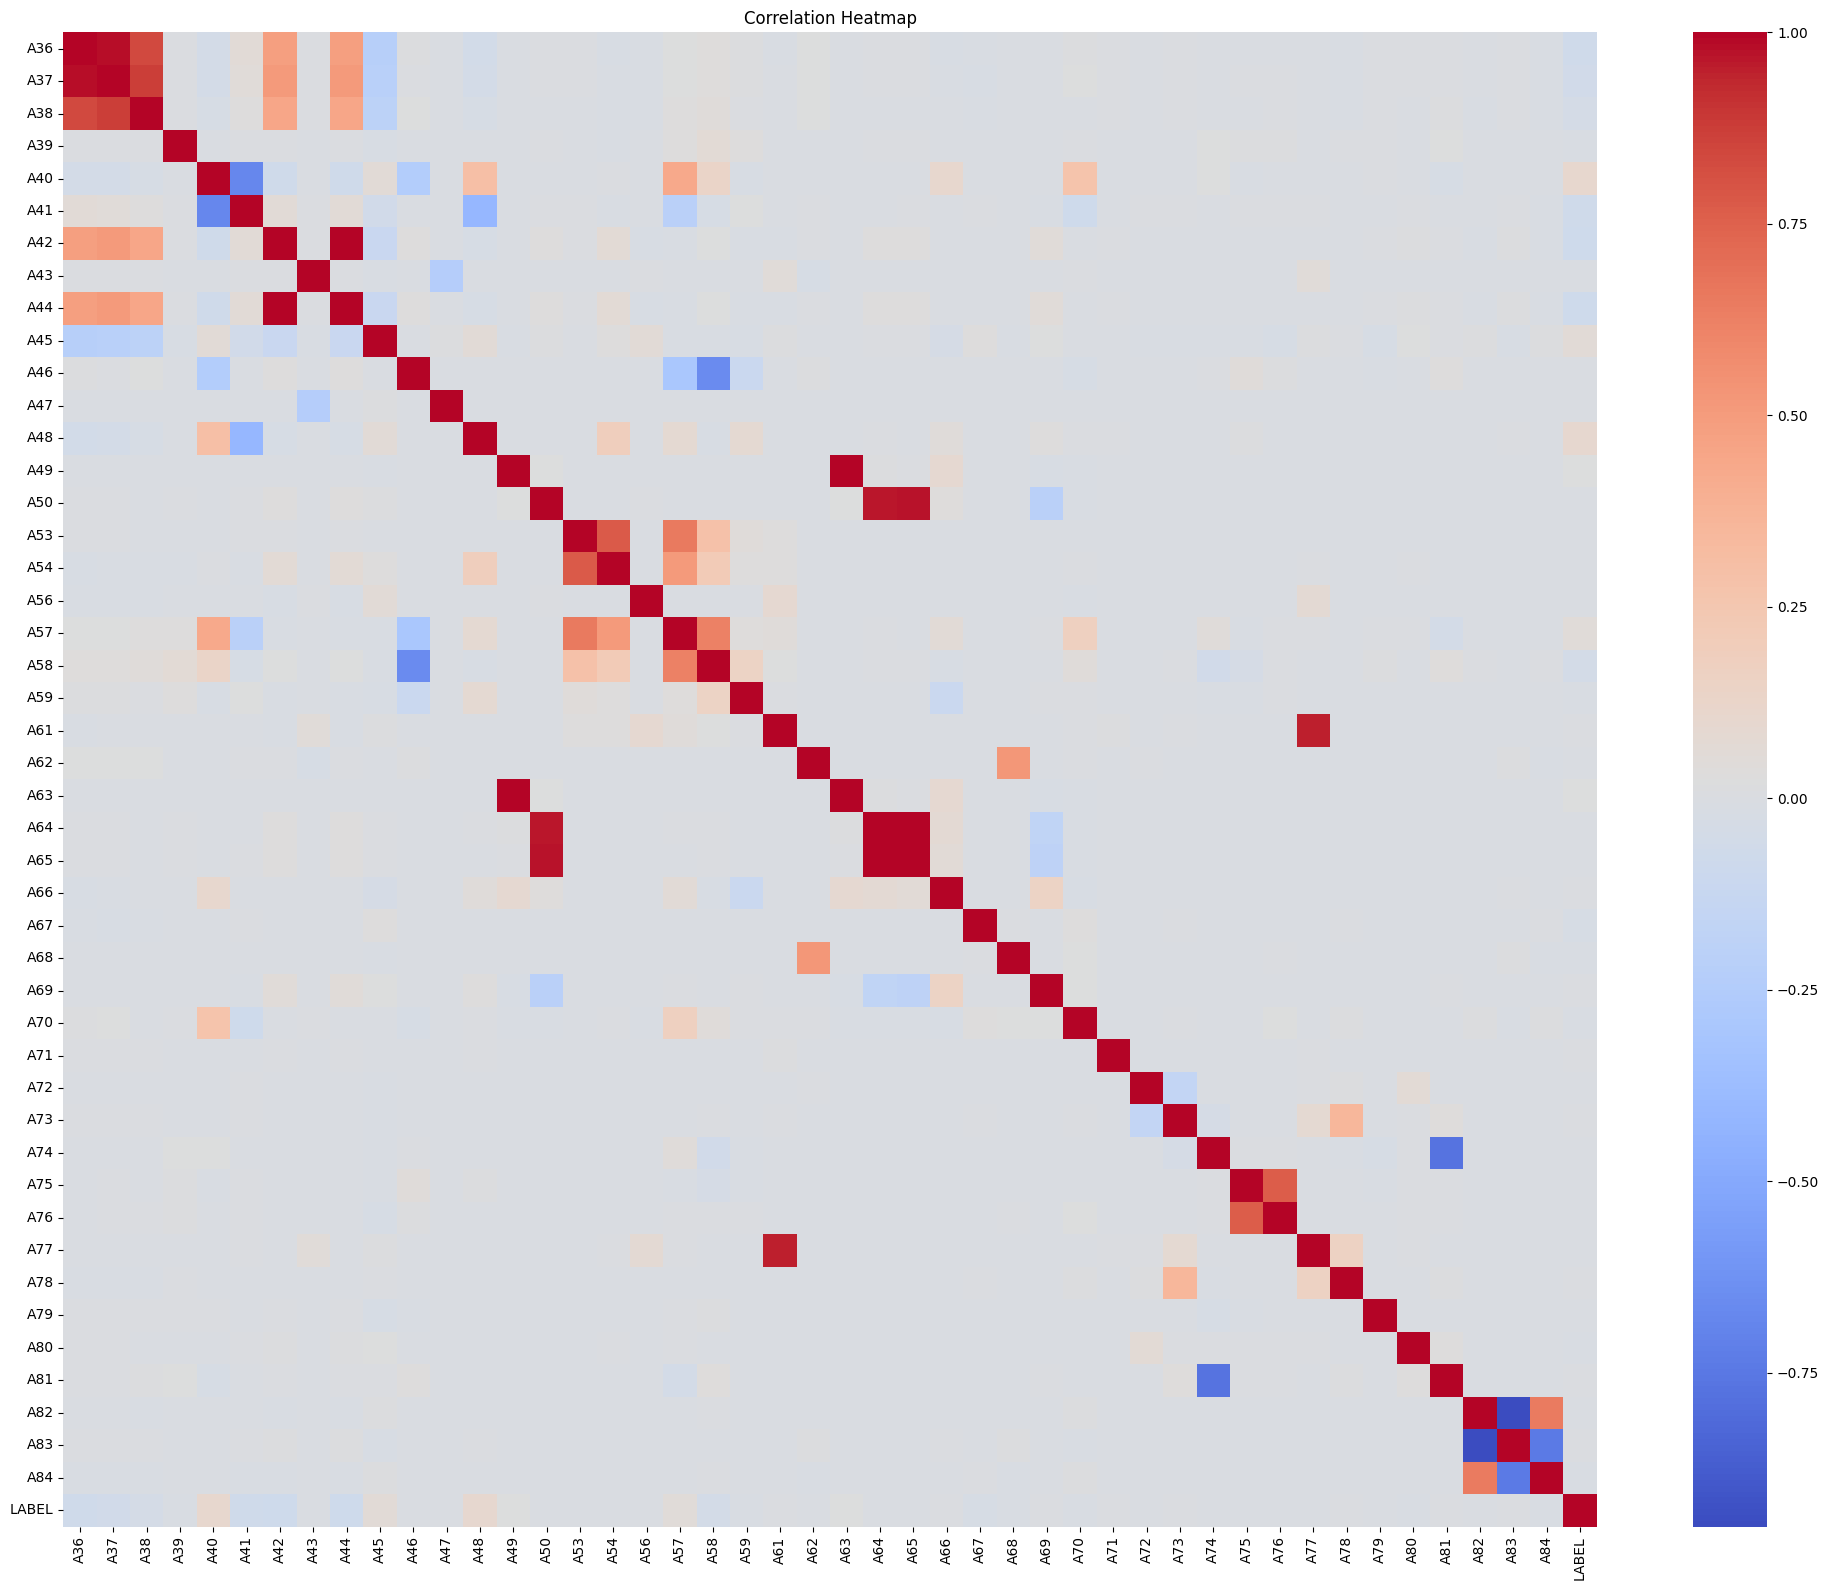


Highly correlated feature pairs:
A36 - A37: 0.98
A36 - A38: 0.83
A37 - A38: 0.87
A42 - A44: 1.00
A49 - A63: 1.00
A50 - A64: 0.96
A50 - A65: 0.97
A61 - A77: 0.95
A64 - A65: 1.00
A82 - A83: -0.95

Number of potential outliers (Isolation Forest): 1033
Number of potential outliers (Z-score > 3): 1804

Skewness of features:
A36       12.724075
A37       14.052905
A38       19.828282
A39       96.000040
A40       30.292567
A41      -42.240885
A42       15.971232
A43      -91.833629
A44       15.971232
A45        0.626105
A46      -74.995661
A47       96.307699
A48       40.801647
A49       87.686930
A50       93.168928
A53      100.875122
A54       63.108119
A56       72.204154
A57       44.201515
A58       51.840519
A59      -14.798890
A61       95.066931
A62       13.753572
A63       87.678609
A64      100.088898
A65       99.823600
A66       31.650304
A67       14.858733
A68       85.960042
A69       28.500928
A70       10.059827
A71      -71.978869
A72       55.311437
A73       -5.67981

C:\Users\dev\AppData\Local\Temp\ipykernel_23604\3597947002.py:171: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


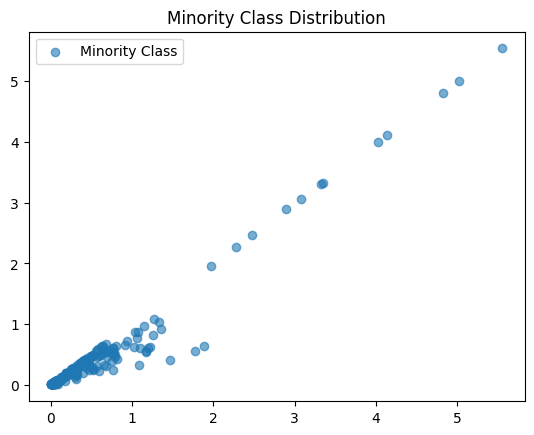

Original class distribution: Counter({0: 10062, 1: 267})
Resampled class distribution: Counter({1: 10063, 0: 10062})


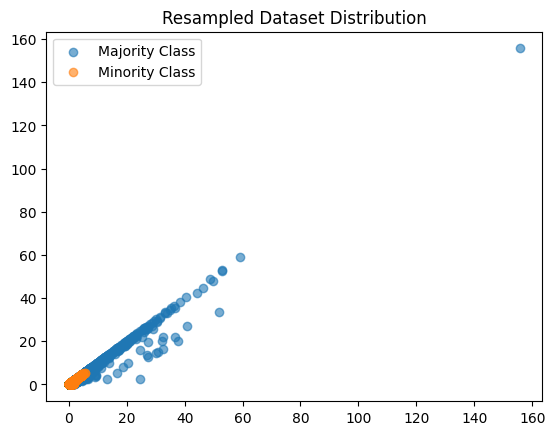

Time taken for kmeans_smote_resampling: 0.01 mins
Time taken for process_pca: 0.00 mins
Comprehensive analysis on MICE processed dataset :
Basic Statistics:
       Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
count                       2.012500e+04                       2.012500e+04   
mean                        4.519228e-17                       2.118388e-18   
std                         1.787012e+00                       1.000021e+00   
min                        -7.841332e+00                      -1.360365e+02   
25%                        -6.208395e-01                       4.440269e-03   
50%                        -3.530034e-01                       8.511489e-03   
75%                         1.324803e-01                       1.485416e-02   
max                         1.193724e+02                       7.799666e+00   

       Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
count         2.012500e+04         2.012500e+04         2.0

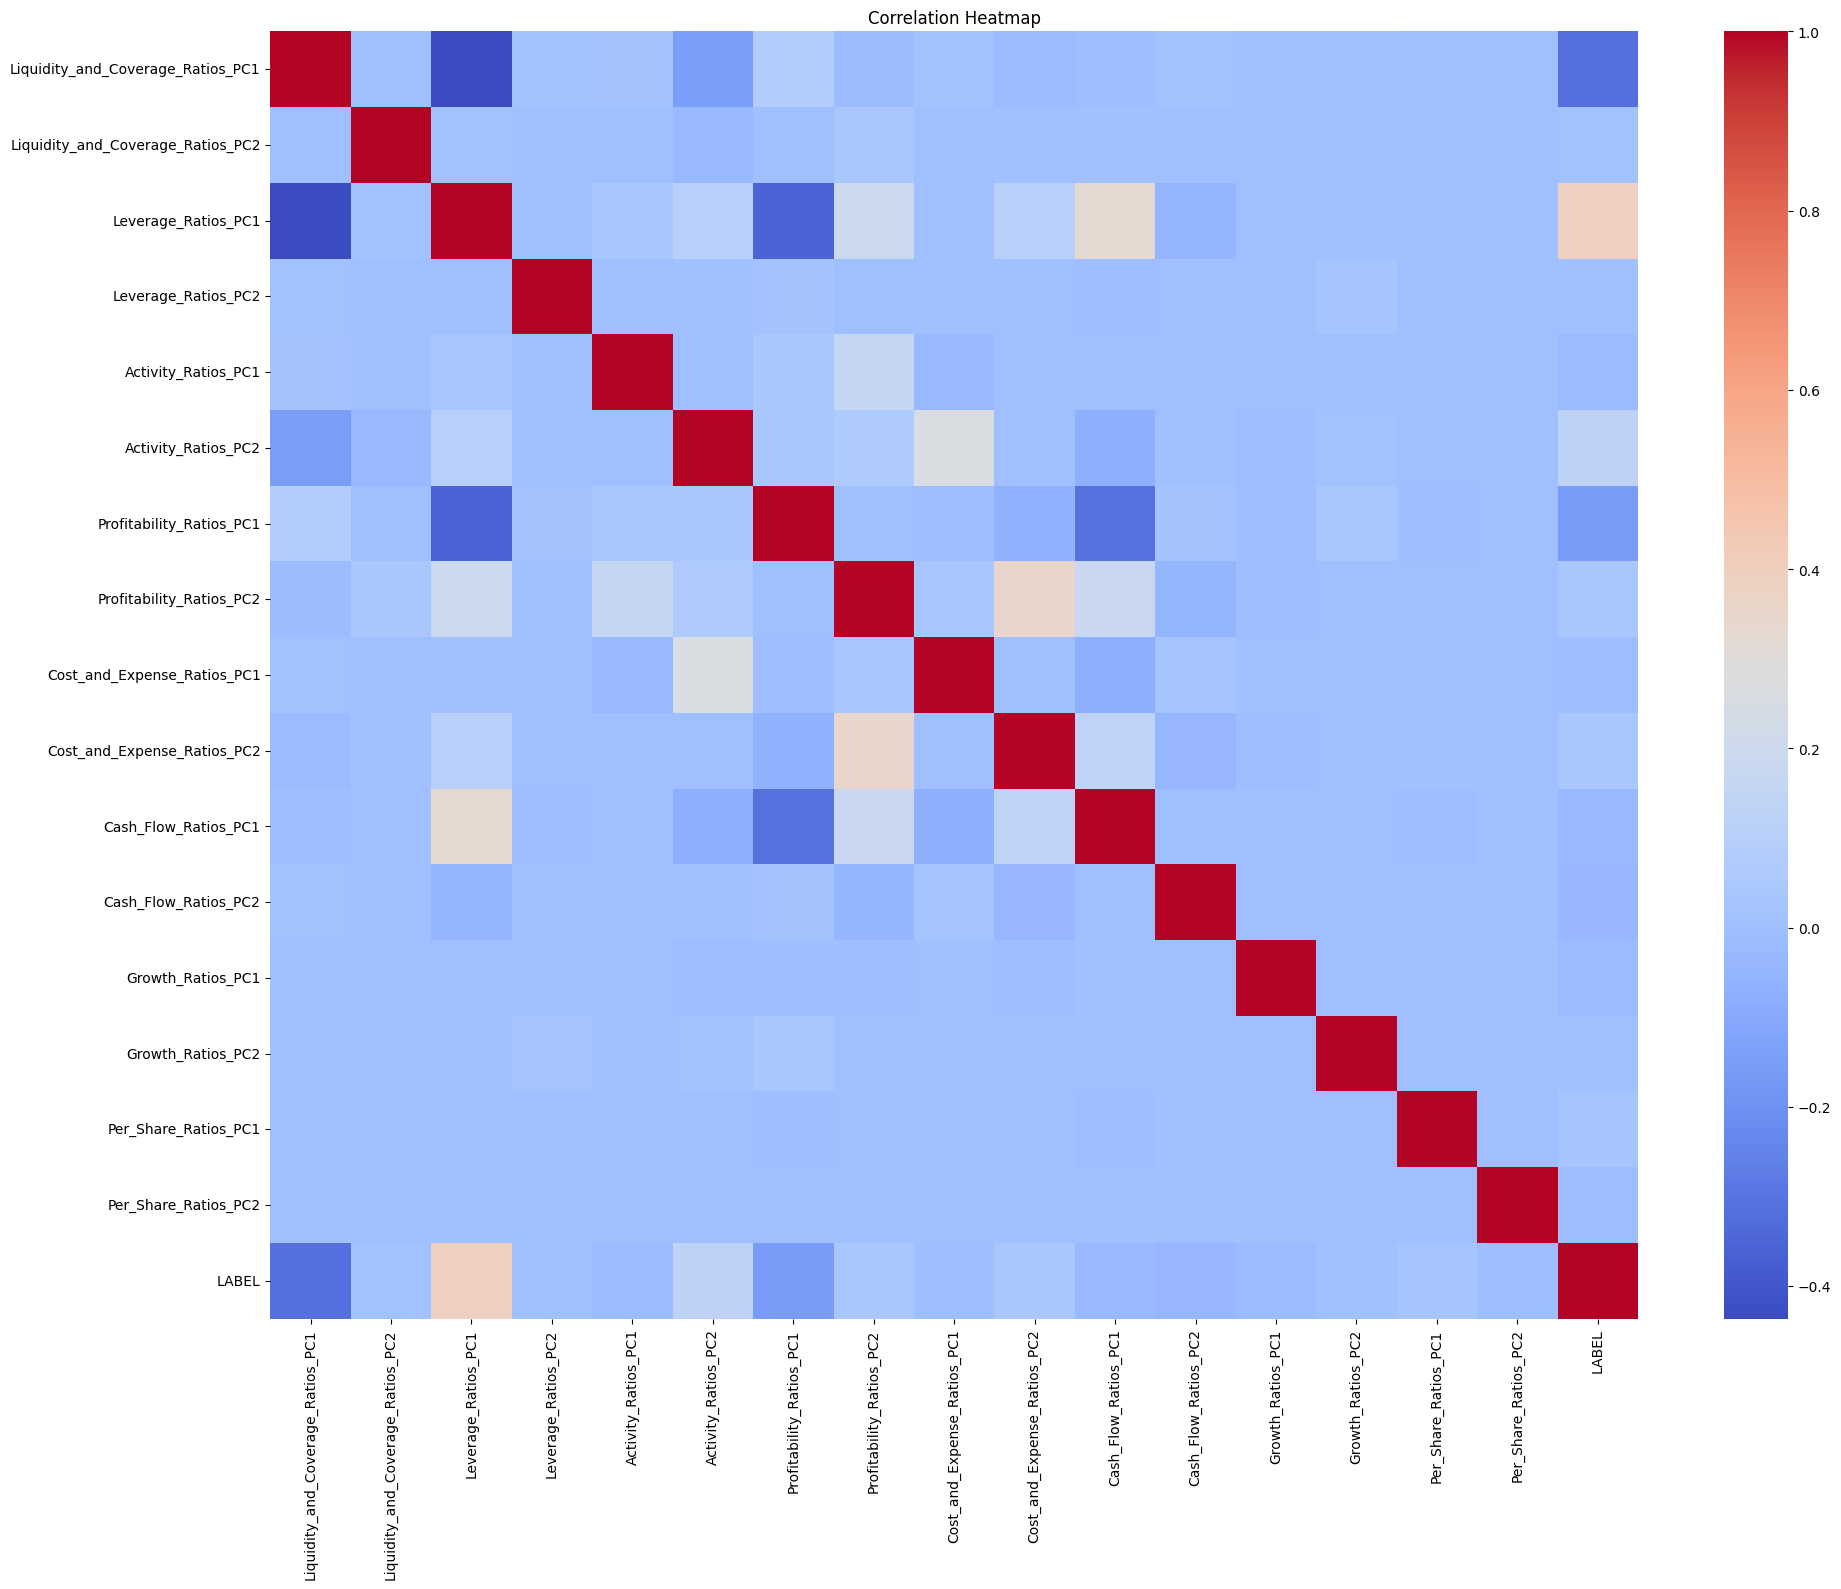


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2013
Number of potential outliers (Z-score > 3): 1461

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     20.965352
Liquidity_and_Coverage_Ratios_PC2   -126.707336
Leverage_Ratios_PC1                    6.765075
Leverage_Ratios_PC2                  -45.339471
Activity_Ratios_PC1                   89.479799
Activity_Ratios_PC2                   32.946907
Profitability_Ratios_PC1               0.184323
Profitability_Ratios_PC2              62.990896
Cost_and_Expense_Ratios_PC1          136.238073
Cost_and_Expense_Ratios_PC2           23.286295
Cash_Flow_Ratios_PC1                  13.745306
Cash_Flow_Ratios_PC2                  33.851644
Growth_Ratios_PC1                     73.846641
Growth_Ratios_PC2                   -115.774302
Per_Share_Ratios_PC1                 -45.792300
Per_Share_Ratios_PC2                   9.983996
LABEL                                 -0.000099
dtype: float64

Kurtosi

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 45)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 22)             │         1,012 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 45)             │         1,035 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,047 (8.00 KB)

 Trainable params: 2,047 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 1.4213 - val_loss: 0.8289
Epoch 2/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.9421 - val_loss: 0.7251
Epoch 3/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 0.9269 - val_loss: 0.6610
Epoch 4/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.6520 - val_loss: 0.6197
Epoch 5/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.7361 - val_loss: 0.5963
Epoch 6/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.5888 - val_loss: 0.5849
Epoch 7/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.5079 - val_loss: 0.5648
Epoch 8/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 0.5696 - val_loss: 0.5572
Epoch 9/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 0.3976 - val_loss: 0.5520
Epoch 10/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.4005 - val_loss: 0.5450
Epoch 11/35
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 0.4040 - val_loss: 0.5379
Epoch 12/35
351/351 ━━━━━━━━━━

C:\Users\dev\AppData\Local\Temp\ipykernel_23604\3597947002.py:171: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_reprocessed["LABEL"] = df_reprocessed["LABEL"].replace({"Normal": 0, "Distressed": 1}).infer_objects(copy=False)


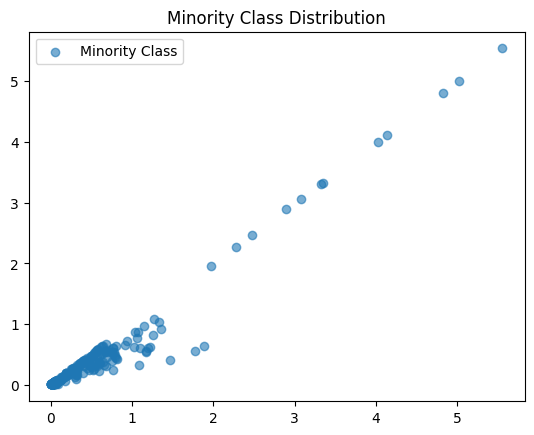

Original class distribution: Counter({0: 13708, 1: 307})
Resampled class distribution: Counter({1: 13709, 0: 13708})


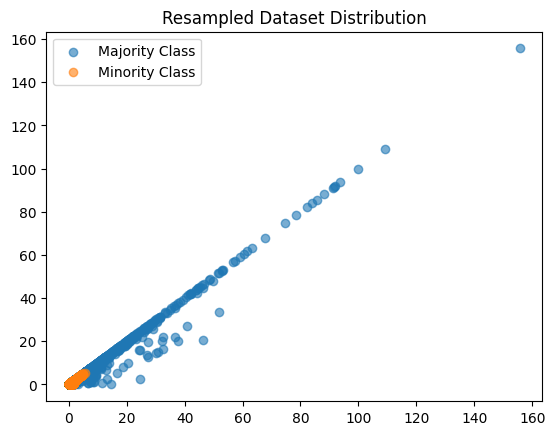

Time taken for kmeans_smote_resampling: 0.01 mins
Time taken for process_pca: 0.00 mins
Comprehensive analysis on Autoencoder processed dataset :
Basic Statistics:
       Liquidity_and_Coverage_Ratios_PC1  Liquidity_and_Coverage_Ratios_PC2  \
count                       2.741700e+04                       2.741700e+04   
mean                       -4.146582e-17                       1.658633e-17   
std                         1.694571e+00                       1.006944e+00   
min                        -8.574441e+00                      -5.672159e+01   
25%                        -5.375918e-01                      -1.733345e-01   
50%                        -3.079429e-01                       1.886241e-01   
75%                         8.032552e-02                       3.413969e-01   
max                         1.057494e+02                       3.156413e+01   

       Leverage_Ratios_PC1  Leverage_Ratios_PC2  Activity_Ratios_PC1  \
count         2.741700e+04         2.741700e+04     

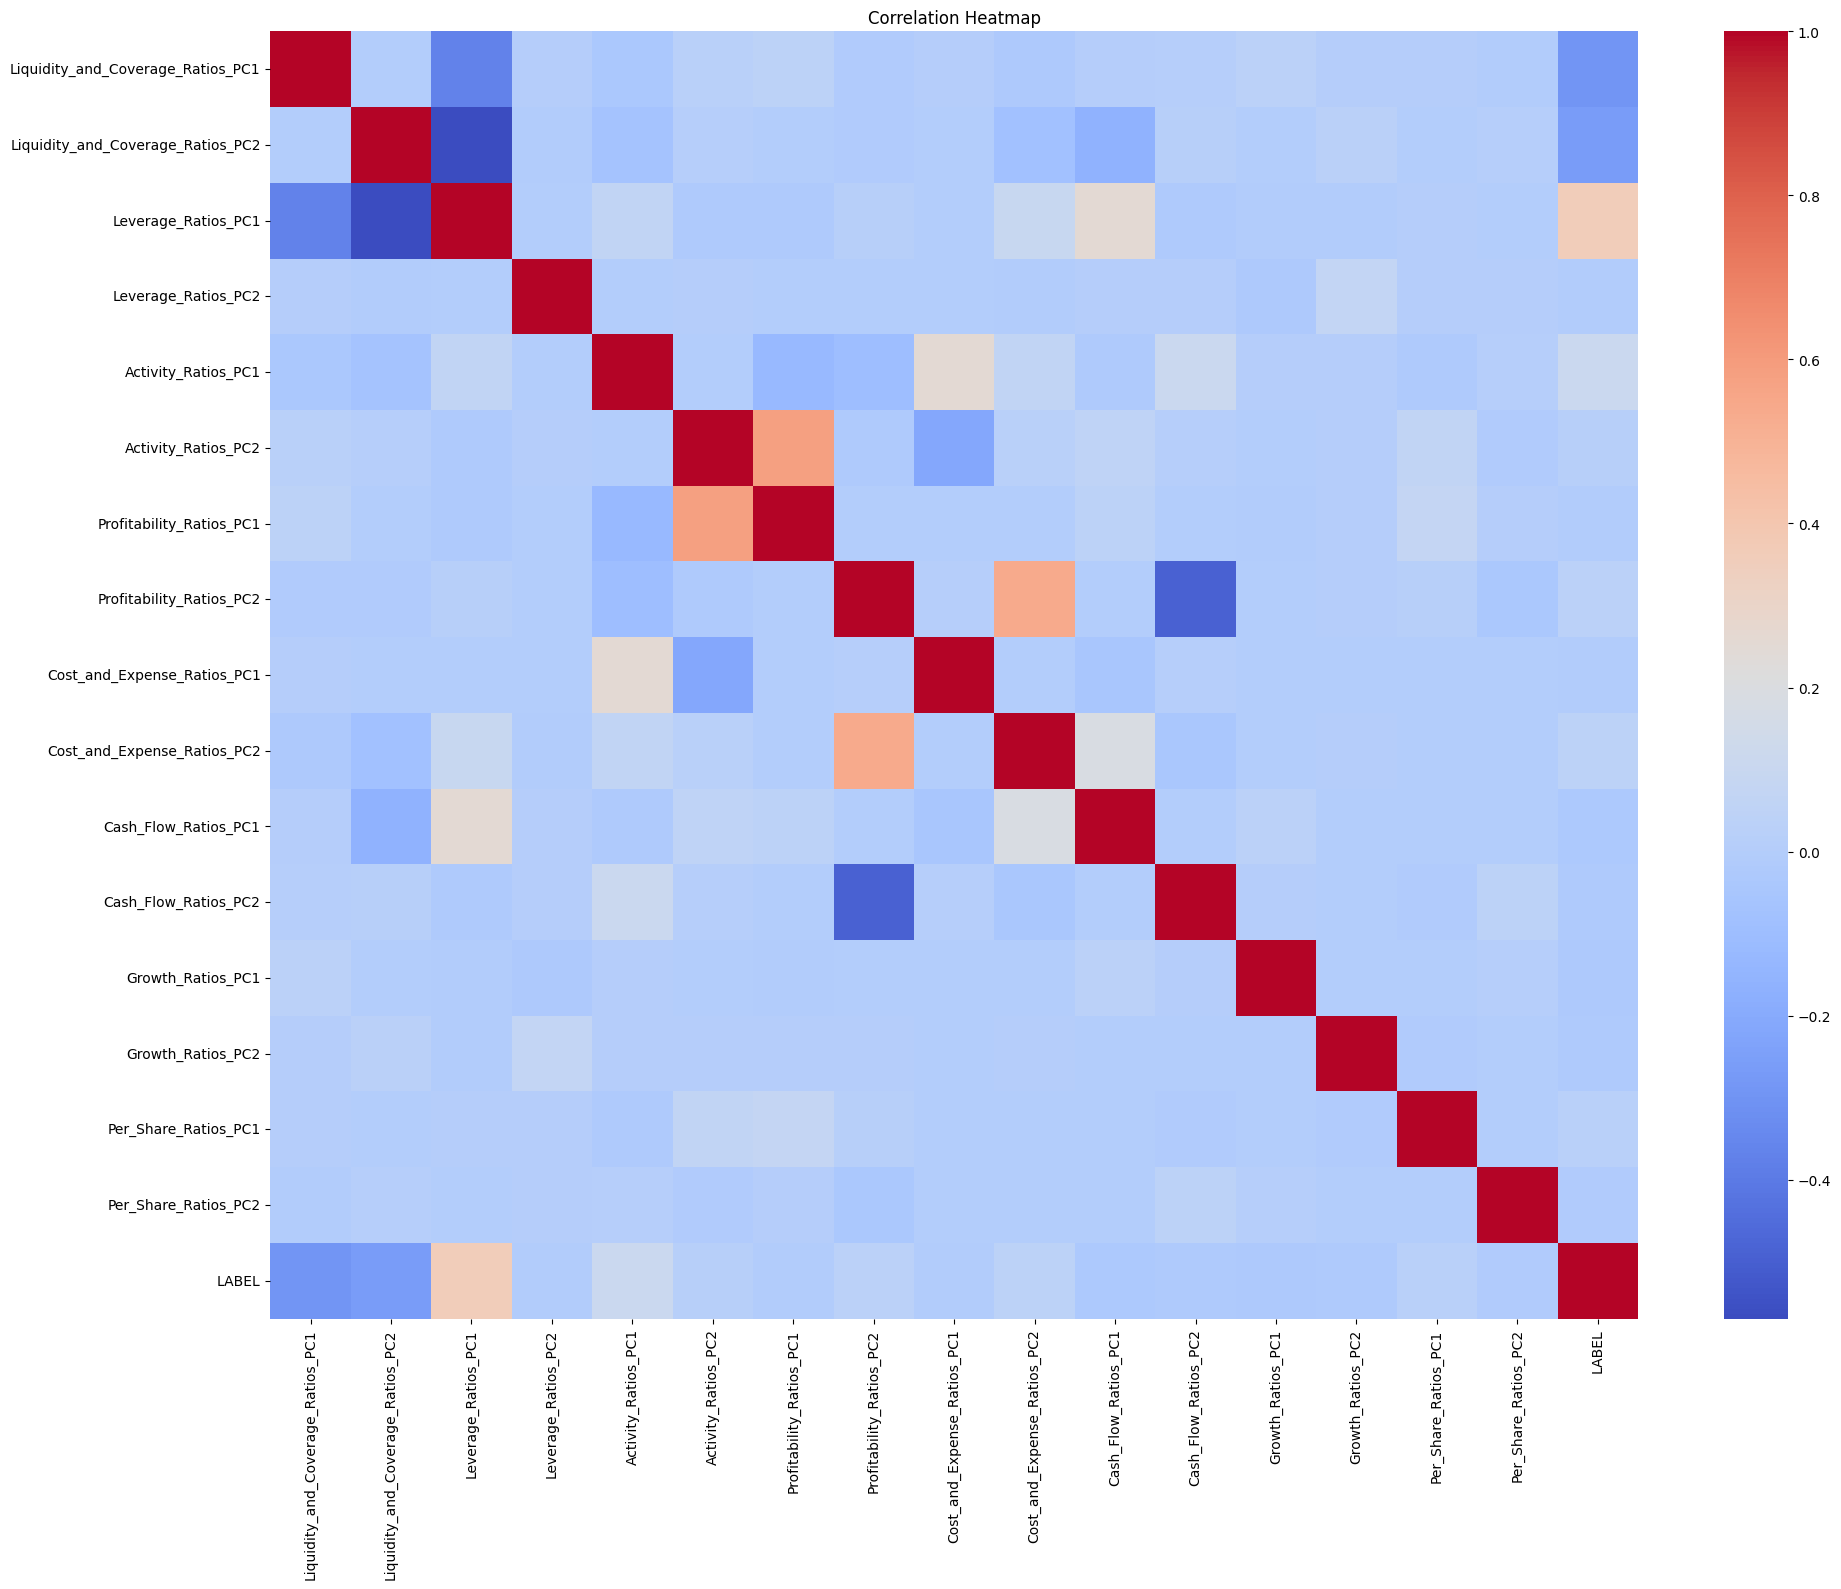


Highly correlated feature pairs:

Number of potential outliers (Isolation Forest): 2742
Number of potential outliers (Z-score > 3): 1976

Skewness of features:
Liquidity_and_Coverage_Ratios_PC1     17.561471
Liquidity_and_Coverage_Ratios_PC2    -16.737583
Leverage_Ratios_PC1                    9.724041
Leverage_Ratios_PC2                   56.740175
Activity_Ratios_PC1                    5.383628
Activity_Ratios_PC2                   76.051083
Profitability_Ratios_PC1             158.047501
Profitability_Ratios_PC2             -25.488528
Cost_and_Expense_Ratios_PC1          158.277821
Cost_and_Expense_Ratios_PC2           30.547462
Cash_Flow_Ratios_PC1                  18.834770
Cash_Flow_Ratios_PC2                  43.973152
Growth_Ratios_PC1                     64.622267
Growth_Ratios_PC2                     85.796616
Per_Share_Ratios_PC1                 -52.756438
Per_Share_Ratios_PC2                  11.448283
LABEL                                 -0.000073
dtype: float64

Kurtosi

In [18]:
main(df)

### Observations

- This data is non linear and the imputations and preprocessing methods have worked in capturing the patterns and emitting it in the processed datasets, as they seem to have non linear relationships as well.
  
- The pearson vs spearman difference hints that there is a non linear data pattern

- The multicollinearity and related variables are now sorted after the PCA- scatter plot shows the patterns

- Isolation and z score for dataset prior and after - shows how well the imputation and class imbalance has happened - also shows how it is done through various metrics in isolation and z score